In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 64)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 64)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.1019
Epoch 00001: val_loss improved from inf to 2.65501, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/001-2.6550.hdf5
36805/36805 [==============================] - 32s 863us/sample - loss: 2.7205 - acc: 0.1019 - val_loss: 2.6550 - val_acc: 0.1628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5928 - acc: 0.1740
Epoch 00002: val_loss improved from 2.65501 to 2.44915, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/002-2.4492.hdf5
36805/36805 [==============================] - 30s 806us/sample - loss: 2.5928 - acc: 0.1740 - val_loss: 2.4492 - val_acc: 0.2485
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4121 - acc: 0.2174
Epoch 00003: val_loss improved from 2.44915 to 2.24447,

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6501 - acc: 0.4703
Epoch 00022: val_loss improved from 1.48174 to 1.46256, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/022-1.4626.hdf5
36805/36805 [==============================] - 30s 803us/sample - loss: 1.6505 - acc: 0.4703 - val_loss: 1.4626 - val_acc: 0.5705
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6317 - acc: 0.4779
Epoch 00023: val_loss improved from 1.46256 to 1.45174, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/023-1.4517.hdf5
36805/36805 [==============================] - 30s 803us/sample - loss: 1.6316 - acc: 0.4780 - val_loss: 1.4517 - val_acc: 0.5747
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6258 - acc: 0.4830
Epoch 00024: val_loss improved from 1.45174 to 1.43599, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/024-1.436

Epoch 44/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4028 - acc: 0.5624
Epoch 00044: val_loss improved from 1.20955 to 1.19913, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/044-1.1991.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 1.4034 - acc: 0.5625 - val_loss: 1.1991 - val_acc: 0.6497
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3980 - acc: 0.5613
Epoch 00045: val_loss improved from 1.19913 to 1.18828, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/045-1.1883.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.3980 - acc: 0.5613 - val_loss: 1.1883 - val_acc: 0.6539
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3895 - acc: 0.5640
Epoch 00046: val_loss improved from 1.18828 to 1.18162, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/046-1.181

36800/36805 [============================>.] - ETA: 0s - loss: 1.2696 - acc: 0.6074
Epoch 00066: val_loss did not improve from 1.05678
36805/36805 [==============================] - 30s 805us/sample - loss: 1.2695 - acc: 0.6074 - val_loss: 1.0585 - val_acc: 0.6956
Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2660 - acc: 0.6099
Epoch 00067: val_loss improved from 1.05678 to 1.04511, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/067-1.0451.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.2661 - acc: 0.6099 - val_loss: 1.0451 - val_acc: 0.7021
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2565 - acc: 0.6113
Epoch 00068: val_loss improved from 1.04511 to 1.04268, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/068-1.0427.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.2564 - acc: 0.6114 - val_loss: 1.

Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1846 - acc: 0.6371
Epoch 00089: val_loss did not improve from 0.96313
36805/36805 [==============================] - 30s 807us/sample - loss: 1.1845 - acc: 0.6371 - val_loss: 0.9657 - val_acc: 0.7261
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1802 - acc: 0.6398
Epoch 00090: val_loss did not improve from 0.96313
36805/36805 [==============================] - 30s 803us/sample - loss: 1.1802 - acc: 0.6397 - val_loss: 0.9635 - val_acc: 0.7263
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1764 - acc: 0.6387
Epoch 00091: val_loss improved from 0.96313 to 0.95634, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/091-0.9563.hdf5
36805/36805 [==============================] - 30s 806us/sample - loss: 1.1764 - acc: 0.6387 - val_loss: 0.9563 - val_acc: 0.7300
Epoch 92/500
36736/36805 [============================>.] - ETA: 

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1255 - acc: 0.6562
Epoch 00113: val_loss did not improve from 0.90158
36805/36805 [==============================] - 30s 805us/sample - loss: 1.1255 - acc: 0.6562 - val_loss: 0.9081 - val_acc: 0.7452
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1230 - acc: 0.6582
Epoch 00114: val_loss improved from 0.90158 to 0.89648, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/114-0.8965.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.1229 - acc: 0.6582 - val_loss: 0.8965 - val_acc: 0.7468
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1170 - acc: 0.6608
Epoch 00115: val_loss did not improve from 0.89648
36805/36805 [==============================] - 29s 801us/sample - loss: 1.1170 - acc: 0.6608 - val_loss: 0.8968 - val_acc: 0.7498
Epoch 116/500
36800/36805 [============================>.] - E

Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0767 - acc: 0.6710
Epoch 00138: val_loss improved from 0.85392 to 0.85314, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/138-0.8531.hdf5
36805/36805 [==============================] - 30s 806us/sample - loss: 1.0767 - acc: 0.6710 - val_loss: 0.8531 - val_acc: 0.7603
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0783 - acc: 0.6720
Epoch 00139: val_loss did not improve from 0.85314
36805/36805 [==============================] - 30s 804us/sample - loss: 1.0784 - acc: 0.6719 - val_loss: 0.8561 - val_acc: 0.7568
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0786 - acc: 0.6722
Epoch 00140: val_loss improved from 0.85314 to 0.84700, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/140-0.8470.hdf5
36805/36805 [==============================] - 30s 803us/sample - loss: 1.0786 - acc: 0.672

36800/36805 [============================>.] - ETA: 0s - loss: 1.0448 - acc: 0.6845
Epoch 00162: val_loss improved from 0.81938 to 0.81553, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/162-0.8155.hdf5
36805/36805 [==============================] - 30s 806us/sample - loss: 1.0448 - acc: 0.6845 - val_loss: 0.8155 - val_acc: 0.7727
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0454 - acc: 0.6827
Epoch 00163: val_loss did not improve from 0.81553
36805/36805 [==============================] - 30s 803us/sample - loss: 1.0454 - acc: 0.6827 - val_loss: 0.8208 - val_acc: 0.7706
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0450 - acc: 0.6852
Epoch 00164: val_loss did not improve from 0.81553
36805/36805 [==============================] - 30s 802us/sample - loss: 1.0450 - acc: 0.6852 - val_loss: 0.8164 - val_acc: 0.7717
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 1.0222 - acc: 0.6915
Epoch 00188: val_loss improved from 0.79193 to 0.78929, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/188-0.7893.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.0223 - acc: 0.6915 - val_loss: 0.7893 - val_acc: 0.7857
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0165 - acc: 0.6941
Epoch 00189: val_loss did not improve from 0.78929
36805/36805 [==============================] - 30s 803us/sample - loss: 1.0166 - acc: 0.6941 - val_loss: 0.7966 - val_acc: 0.7794
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0194 - acc: 0.6893
Epoch 00190: val_loss did not improve from 0.78929
36805/36805 [==============================] - 30s 802us/sample - loss: 1.0193 - acc: 0.6893 - val_loss: 0.8026 - val_acc: 0.7780
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9992 - acc: 0.6990
Epoch 00215: val_loss did not improve from 0.77000
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9993 - acc: 0.6990 - val_loss: 0.7719 - val_acc: 0.7892
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0008 - acc: 0.6999
Epoch 00216: val_loss did not improve from 0.77000
36805/36805 [==============================] - 29s 797us/sample - loss: 1.0007 - acc: 0.6999 - val_loss: 0.7755 - val_acc: 0.7850
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9997 - acc: 0.7008
Epoch 00217: val_loss improved from 0.77000 to 0.76795, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/217-0.7680.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 0.9997 - acc: 0.7008 - val_loss: 0.7680 - val_acc: 0.7904
Epoch 218/500
36800/36805 [============================>.] - E

Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9846 - acc: 0.7041
Epoch 00242: val_loss improved from 0.75376 to 0.75078, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/242-0.7508.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 0.9845 - acc: 0.7042 - val_loss: 0.7508 - val_acc: 0.7959
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9779 - acc: 0.7053
Epoch 00243: val_loss improved from 0.75078 to 0.74973, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/243-0.7497.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 0.9778 - acc: 0.7053 - val_loss: 0.7497 - val_acc: 0.7927
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9742 - acc: 0.7051
Epoch 00244: val_loss improved from 0.74973 to 0.74493, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/244-0.

Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9676 - acc: 0.7088
Epoch 00270: val_loss improved from 0.73616 to 0.73413, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/270-0.7341.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9676 - acc: 0.7088 - val_loss: 0.7341 - val_acc: 0.8018
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9600 - acc: 0.7109
Epoch 00271: val_loss did not improve from 0.73413
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9602 - acc: 0.7109 - val_loss: 0.7380 - val_acc: 0.8013
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9704 - acc: 0.7083
Epoch 00272: val_loss did not improve from 0.73413
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9704 - acc: 0.7084 - val_loss: 0.7374 - val_acc: 0.8015
Epoch 273/500
36800/36805 [============================>.] - E

Epoch 298/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9518 - acc: 0.7129
Epoch 00298: val_loss did not improve from 0.72327
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9519 - acc: 0.7128 - val_loss: 0.7265 - val_acc: 0.8008
Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9509 - acc: 0.7138
Epoch 00299: val_loss did not improve from 0.72327
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9508 - acc: 0.7138 - val_loss: 0.7255 - val_acc: 0.8032
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9471 - acc: 0.7144
Epoch 00300: val_loss did not improve from 0.72327
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9471 - acc: 0.7144 - val_loss: 0.7276 - val_acc: 0.8013
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9585 - acc: 0.7117
Epoch 00301: val_loss improved from 0.72327 to 0.72210, saving mo

Epoch 325/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9328 - acc: 0.7217
Epoch 00325: val_loss did not improve from 0.70656
36805/36805 [==============================] - 29s 801us/sample - loss: 0.9328 - acc: 0.7216 - val_loss: 0.7136 - val_acc: 0.8069
Epoch 326/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9412 - acc: 0.7189
Epoch 00326: val_loss did not improve from 0.70656
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9412 - acc: 0.7189 - val_loss: 0.7145 - val_acc: 0.8050
Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9409 - acc: 0.7171
Epoch 00327: val_loss did not improve from 0.70656
36805/36805 [==============================] - 29s 796us/sample - loss: 0.9413 - acc: 0.7170 - val_loss: 0.7140 - val_acc: 0.8060
Epoch 328/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9328 - acc: 0.7192
Epoch 00328: val_loss improved from 0.70656 to 0.70569, saving mo

Epoch 353/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9305 - acc: 0.7186
Epoch 00353: val_loss did not improve from 0.69232
36805/36805 [==============================] - 29s 799us/sample - loss: 0.9305 - acc: 0.7186 - val_loss: 0.6982 - val_acc: 0.8085
Epoch 354/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9307 - acc: 0.7190
Epoch 00354: val_loss did not improve from 0.69232
36805/36805 [==============================] - 29s 796us/sample - loss: 0.9306 - acc: 0.7190 - val_loss: 0.6964 - val_acc: 0.8125
Epoch 355/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9263 - acc: 0.7222
Epoch 00355: val_loss did not improve from 0.69232
36805/36805 [==============================] - 29s 794us/sample - loss: 0.9263 - acc: 0.7222 - val_loss: 0.6994 - val_acc: 0.8099
Epoch 356/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9273 - acc: 0.7210
Epoch 00356: val_loss did not improve from 0.69232
36805/36805 [=

Epoch 381/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9139 - acc: 0.7249
Epoch 00381: val_loss did not improve from 0.68715
36805/36805 [==============================] - 29s 799us/sample - loss: 0.9138 - acc: 0.7249 - val_loss: 0.6904 - val_acc: 0.8139
Epoch 382/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9148 - acc: 0.7242
Epoch 00382: val_loss improved from 0.68715 to 0.68453, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/382-0.6845.hdf5
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9148 - acc: 0.7241 - val_loss: 0.6845 - val_acc: 0.8148
Epoch 383/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9159 - acc: 0.7254
Epoch 00383: val_loss did not improve from 0.68453
36805/36805 [==============================] - 29s 796us/sample - loss: 0.9158 - acc: 0.7254 - val_loss: 0.6933 - val_acc: 0.8113
Epoch 384/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.9016 - acc: 0.7283
Epoch 00408: val_loss improved from 0.68023 to 0.67500, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/408-0.6750.hdf5
36805/36805 [==============================] - 30s 804us/sample - loss: 0.9016 - acc: 0.7283 - val_loss: 0.6750 - val_acc: 0.8148
Epoch 409/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9020 - acc: 0.7276
Epoch 00409: val_loss improved from 0.67500 to 0.67378, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/409-0.6738.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 0.9019 - acc: 0.7277 - val_loss: 0.6738 - val_acc: 0.8160
Epoch 410/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8997 - acc: 0.7280
Epoch 00410: val_loss did not improve from 0.67378
36805/36805 [==============================] - 29s 800us/sample - loss: 0.8998 - acc: 0.7280 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.8958 - acc: 0.7326
Epoch 00435: val_loss did not improve from 0.66862
36805/36805 [==============================] - 30s 802us/sample - loss: 0.8958 - acc: 0.7326 - val_loss: 0.6754 - val_acc: 0.8174
Epoch 436/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8991 - acc: 0.7317
Epoch 00436: val_loss did not improve from 0.66862
36805/36805 [==============================] - 30s 802us/sample - loss: 0.8990 - acc: 0.7317 - val_loss: 0.6862 - val_acc: 0.8123
Epoch 437/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8907 - acc: 0.7299
Epoch 00437: val_loss did not improve from 0.66862
36805/36805 [==============================] - 29s 792us/sample - loss: 0.8906 - acc: 0.7299 - val_loss: 0.6746 - val_acc: 0.8199
Epoch 438/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8986 - acc: 0.7313
Epoch 00438: val_loss did not improve from 0.66862
36805/36805 [===============

Epoch 463/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8854 - acc: 0.7339
Epoch 00463: val_loss did not improve from 0.66319
36805/36805 [==============================] - 29s 796us/sample - loss: 0.8854 - acc: 0.7338 - val_loss: 0.6671 - val_acc: 0.8230
Epoch 464/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8818 - acc: 0.7349
Epoch 00464: val_loss improved from 0.66319 to 0.66157, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/464-0.6616.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 0.8820 - acc: 0.7348 - val_loss: 0.6616 - val_acc: 0.8251
Epoch 465/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8854 - acc: 0.7349
Epoch 00465: val_loss did not improve from 0.66157
36805/36805 [==============================] - 29s 797us/sample - loss: 0.8853 - acc: 0.7349 - val_loss: 0.6689 - val_acc: 0.8202
Epoch 466/500
36736/36805 [============================>.] - E

Epoch 491/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8805 - acc: 0.7360
Epoch 00491: val_loss did not improve from 0.65278
36805/36805 [==============================] - 29s 796us/sample - loss: 0.8805 - acc: 0.7360 - val_loss: 0.6619 - val_acc: 0.8213
Epoch 492/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8815 - acc: 0.7354
Epoch 00492: val_loss did not improve from 0.65278
36805/36805 [==============================] - 29s 795us/sample - loss: 0.8816 - acc: 0.7354 - val_loss: 0.6646 - val_acc: 0.8192
Epoch 493/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8799 - acc: 0.7340
Epoch 00493: val_loss improved from 0.65278 to 0.65259, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_3_conv_checkpoint/493-0.6526.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 0.8798 - acc: 0.7340 - val_loss: 0.6526 - val_acc: 0.8258
Epoch 494/500
36800/36805 [============================>.] - E

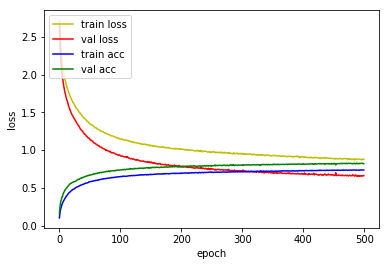

4815/4815 [==============================] - 2s 364us/sample - loss: 0.7133 - acc: 0.7884
Loss: 0.7133490382944189 Accuracy: 0.78836966

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6791 - acc: 0.1231
Epoch 00001: val_loss improved from inf to 2.48872, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/001-2.4887.hdf5
36805/36805 [==============================] - 31s 850us/sample - loss: 2.6791 - acc: 0.1231 - val_loss: 2.4887 - val_acc: 0.2360
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3530 - acc: 0.2358
Epoch 00002: val_loss improved from 2.48872 to 2.11616, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/002-2.1162.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 2.3528 - acc: 0.2358 - val_loss: 2.1162 - val_acc: 0.3515
Epoch 3/500
36800/36805 [============================>.] - ETA

36736/36805 [============================>.] - ETA: 0s - loss: 1.3733 - acc: 0.5644
Epoch 00022: val_loss improved from 1.19728 to 1.17378, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/022-1.1738.hdf5
36805/36805 [==============================] - 30s 810us/sample - loss: 1.3730 - acc: 0.5645 - val_loss: 1.1738 - val_acc: 0.6534
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3564 - acc: 0.5676
Epoch 00023: val_loss improved from 1.17378 to 1.14696, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/023-1.1470.hdf5
36805/36805 [==============================] - 30s 812us/sample - loss: 1.3568 - acc: 0.5676 - val_loss: 1.1470 - val_acc: 0.6627
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3415 - acc: 0.5745
Epoch 00024: val_loss improved from 1.14696 to 1.13450, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/024-1.1345.hdf5
36805/

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1166 - acc: 0.6517
Epoch 00045: val_loss improved from 0.92067 to 0.91858, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/045-0.9186.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.1165 - acc: 0.6517 - val_loss: 0.9186 - val_acc: 0.7261
Epoch 46/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1088 - acc: 0.6569
Epoch 00046: val_loss improved from 0.91858 to 0.91354, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/046-0.9135.hdf5
36805/36805 [==============================] - 30s 802us/sample - loss: 1.1084 - acc: 0.6570 - val_loss: 0.9135 - val_acc: 0.7268
Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1017 - acc: 0.6580
Epoch 00047: val_loss improved from 0.91354 to 0.90042, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/047-0.900

Epoch 69/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9878 - acc: 0.6985
Epoch 00069: val_loss improved from 0.80562 to 0.78799, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/069-0.7880.hdf5
36805/36805 [==============================] - 30s 806us/sample - loss: 0.9873 - acc: 0.6985 - val_loss: 0.7880 - val_acc: 0.7703
Epoch 70/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9830 - acc: 0.6995
Epoch 00070: val_loss did not improve from 0.78799
36805/36805 [==============================] - 29s 800us/sample - loss: 0.9831 - acc: 0.6996 - val_loss: 0.7897 - val_acc: 0.7673
Epoch 71/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9778 - acc: 0.7009
Epoch 00071: val_loss improved from 0.78799 to 0.78393, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/071-0.7839.hdf5
36805/36805 [==============================] - 30s 804us/sample - loss: 0.9782 - acc: 0.7007 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.9048 - acc: 0.7268
Epoch 00095: val_loss did not improve from 0.72029
36805/36805 [==============================] - 30s 803us/sample - loss: 0.9048 - acc: 0.7268 - val_loss: 0.7215 - val_acc: 0.7959
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8968 - acc: 0.7290
Epoch 00096: val_loss improved from 0.72029 to 0.71180, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/096-0.7118.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.8969 - acc: 0.7290 - val_loss: 0.7118 - val_acc: 0.7976
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9014 - acc: 0.7255
Epoch 00097: val_loss did not improve from 0.71180
36805/36805 [==============================] - 29s 801us/sample - loss: 0.9013 - acc: 0.7255 - val_loss: 0.7127 - val_acc: 0.7994
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36736/36805 [============================>.] - ETA: 0s - loss: 0.8391 - acc: 0.7482
Epoch 00121: val_loss did not improve from 0.66238
36805/36805 [==============================] - 29s 799us/sample - loss: 0.8398 - acc: 0.7481 - val_loss: 0.6675 - val_acc: 0.8155
Epoch 122/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8445 - acc: 0.7468
Epoch 00122: val_loss did not improve from 0.66238
36805/36805 [==============================] - 30s 810us/sample - loss: 0.8450 - acc: 0.7467 - val_loss: 0.6752 - val_acc: 0.8143
Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8335 - acc: 0.7490
Epoch 00123: val_loss improved from 0.66238 to 0.65415, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/123-0.6541.hdf5
36805/36805 [==============================] - 30s 810us/sample - loss: 0.8335 - acc: 0.7490 - val_loss: 0.6541 - val_acc: 0.8265
Epoch 124/500
36736/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.8007 - acc: 0.7629
Epoch 00146: val_loss improved from 0.61898 to 0.61761, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/146-0.6176.hdf5
36805/36805 [==============================] - 30s 814us/sample - loss: 0.8006 - acc: 0.7629 - val_loss: 0.6176 - val_acc: 0.8353
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7981 - acc: 0.7620
Epoch 00147: val_loss improved from 0.61761 to 0.61581, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/147-0.6158.hdf5
36805/36805 [==============================] - 30s 802us/sample - loss: 0.7981 - acc: 0.7620 - val_loss: 0.6158 - val_acc: 0.8358
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7960 - acc: 0.7621
Epoch 00148: val_loss did not improve from 0.61581
36805/36805 [==============================] - 30s 813us/sample - loss: 0.7961 - acc: 0.7621 - val_loss: 

Epoch 172/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7605 - acc: 0.7759
Epoch 00172: val_loss did not improve from 0.58933
36805/36805 [==============================] - 30s 810us/sample - loss: 0.7608 - acc: 0.7758 - val_loss: 0.6047 - val_acc: 0.8409
Epoch 173/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7666 - acc: 0.7743
Epoch 00173: val_loss did not improve from 0.58933
36805/36805 [==============================] - 30s 802us/sample - loss: 0.7670 - acc: 0.7742 - val_loss: 0.5917 - val_acc: 0.8430
Epoch 174/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7596 - acc: 0.7745
Epoch 00174: val_loss improved from 0.58933 to 0.58737, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/174-0.5874.hdf5
36805/36805 [==============================] - 30s 812us/sample - loss: 0.7602 - acc: 0.7743 - val_loss: 0.5874 - val_acc: 0.8409
Epoch 175/500
36736/36805 [============================>.] - E

Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7353 - acc: 0.7845
Epoch 00199: val_loss improved from 0.56475 to 0.56397, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/199-0.5640.hdf5
36805/36805 [==============================] - 30s 809us/sample - loss: 0.7354 - acc: 0.7845 - val_loss: 0.5640 - val_acc: 0.8474
Epoch 200/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7287 - acc: 0.7830
Epoch 00200: val_loss did not improve from 0.56397
36805/36805 [==============================] - 30s 803us/sample - loss: 0.7286 - acc: 0.7831 - val_loss: 0.5664 - val_acc: 0.8505
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7287 - acc: 0.7835
Epoch 00201: val_loss did not improve from 0.56397
36805/36805 [==============================] - 29s 800us/sample - loss: 0.7287 - acc: 0.7835 - val_loss: 0.5643 - val_acc: 0.8491
Epoch 202/500
36736/36805 [============================>.] - E

36736/36805 [============================>.] - ETA: 0s - loss: 0.7098 - acc: 0.7907
Epoch 00225: val_loss did not improve from 0.54155
36805/36805 [==============================] - 30s 810us/sample - loss: 0.7098 - acc: 0.7907 - val_loss: 0.5452 - val_acc: 0.8549
Epoch 226/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7048 - acc: 0.7918
Epoch 00226: val_loss did not improve from 0.54155
36805/36805 [==============================] - 30s 807us/sample - loss: 0.7050 - acc: 0.7918 - val_loss: 0.5549 - val_acc: 0.8532
Epoch 227/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7021 - acc: 0.7921
Epoch 00227: val_loss improved from 0.54155 to 0.53861, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/227-0.5386.hdf5
36805/36805 [==============================] - 30s 810us/sample - loss: 0.7019 - acc: 0.7921 - val_loss: 0.5386 - val_acc: 0.8577
Epoch 228/500
36736/36805 [============================>.] - ETA: 0s - loss:

Epoch 253/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6751 - acc: 0.7990
Epoch 00253: val_loss improved from 0.52111 to 0.51793, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/253-0.5179.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 0.6751 - acc: 0.7990 - val_loss: 0.5179 - val_acc: 0.8630
Epoch 254/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6815 - acc: 0.7986
Epoch 00254: val_loss improved from 0.51793 to 0.51521, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/254-0.5152.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 0.6815 - acc: 0.7986 - val_loss: 0.5152 - val_acc: 0.8654
Epoch 255/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.8019
Epoch 00255: val_loss did not improve from 0.51521
36805/36805 [==============================] - 30s 818us/sample - loss: 0.6713 - acc: 0.801

Epoch 280/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6522 - acc: 0.8064
Epoch 00280: val_loss did not improve from 0.49845
36805/36805 [==============================] - 30s 804us/sample - loss: 0.6522 - acc: 0.8064 - val_loss: 0.4998 - val_acc: 0.8700
Epoch 281/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6617 - acc: 0.8034
Epoch 00281: val_loss did not improve from 0.49845
36805/36805 [==============================] - 30s 803us/sample - loss: 0.6617 - acc: 0.8034 - val_loss: 0.5014 - val_acc: 0.8651
Epoch 282/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6559 - acc: 0.8058
Epoch 00282: val_loss did not improve from 0.49845
36805/36805 [==============================] - 30s 803us/sample - loss: 0.6560 - acc: 0.8058 - val_loss: 0.5124 - val_acc: 0.8642
Epoch 283/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6562 - acc: 0.8074
Epoch 00283: val_loss did not improve from 0.49845
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.6367 - acc: 0.8111
Epoch 00307: val_loss did not improve from 0.48144
36805/36805 [==============================] - 30s 807us/sample - loss: 0.6374 - acc: 0.8111 - val_loss: 0.4833 - val_acc: 0.8742
Epoch 308/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6366 - acc: 0.8122
Epoch 00308: val_loss did not improve from 0.48144
36805/36805 [==============================] - 30s 806us/sample - loss: 0.6365 - acc: 0.8124 - val_loss: 0.4826 - val_acc: 0.8747
Epoch 309/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6351 - acc: 0.8125- ETA: 0s - loss: 0.6352 - acc: 0.8
Epoch 00309: val_loss improved from 0.48144 to 0.47662, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/309-0.4766.hdf5
36805/36805 [==============================] - 30s 804us/sample - loss: 0.6349 - acc: 0.8125 - val_loss: 0.4766 - val_acc: 0.8740
Epoch 310/500
36800/36805 [==============

Epoch 335/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6158 - acc: 0.8162
Epoch 00335: val_loss did not improve from 0.46178
36805/36805 [==============================] - 30s 803us/sample - loss: 0.6158 - acc: 0.8162 - val_loss: 0.4755 - val_acc: 0.8758
Epoch 336/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6157 - acc: 0.8207- ETA: 0s - loss: 0.6130 - 
Epoch 00336: val_loss did not improve from 0.46178
36805/36805 [==============================] - 30s 806us/sample - loss: 0.6157 - acc: 0.8206 - val_loss: 0.4726 - val_acc: 0.8768
Epoch 337/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6120 - acc: 0.8176
Epoch 00337: val_loss did not improve from 0.46178
36805/36805 [==============================] - 30s 818us/sample - loss: 0.6120 - acc: 0.8176 - val_loss: 0.4667 - val_acc: 0.8754
Epoch 338/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6149 - acc: 0.8207
Epoch 00338: val_loss did not improve 

Epoch 363/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5944 - acc: 0.8249
Epoch 00363: val_loss did not improve from 0.44945
36805/36805 [==============================] - 30s 806us/sample - loss: 0.5943 - acc: 0.8250 - val_loss: 0.4502 - val_acc: 0.8824
Epoch 364/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5929 - acc: 0.8245
Epoch 00364: val_loss did not improve from 0.44945
36805/36805 [==============================] - 30s 803us/sample - loss: 0.5928 - acc: 0.8246 - val_loss: 0.4616 - val_acc: 0.8796
Epoch 365/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5979 - acc: 0.8244
Epoch 00365: val_loss did not improve from 0.44945
36805/36805 [==============================] - 30s 804us/sample - loss: 0.5981 - acc: 0.8244 - val_loss: 0.4499 - val_acc: 0.8831
Epoch 366/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5936 - acc: 0.8254
Epoch 00366: val_loss did not improve from 0.44945
36805/36805 [=

Epoch 391/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5834 - acc: 0.8287
Epoch 00391: val_loss improved from 0.43969 to 0.43915, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/391-0.4391.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 0.5834 - acc: 0.8287 - val_loss: 0.4391 - val_acc: 0.8845
Epoch 392/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5821 - acc: 0.8267
Epoch 00392: val_loss did not improve from 0.43915
36805/36805 [==============================] - 30s 802us/sample - loss: 0.5821 - acc: 0.8267 - val_loss: 0.4481 - val_acc: 0.8852
Epoch 393/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5831 - acc: 0.8275
Epoch 00393: val_loss improved from 0.43915 to 0.43818, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/393-0.4382.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.5831 - acc: 0.827

Epoch 419/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5664 - acc: 0.8326
Epoch 00419: val_loss did not improve from 0.42938
36805/36805 [==============================] - 30s 802us/sample - loss: 0.5665 - acc: 0.8325 - val_loss: 0.4295 - val_acc: 0.8877
Epoch 420/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5672 - acc: 0.8317
Epoch 00420: val_loss did not improve from 0.42938
36805/36805 [==============================] - 30s 802us/sample - loss: 0.5672 - acc: 0.8317 - val_loss: 0.4365 - val_acc: 0.8873
Epoch 421/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5649 - acc: 0.8328
Epoch 00421: val_loss did not improve from 0.42938
36805/36805 [==============================] - 30s 803us/sample - loss: 0.5651 - acc: 0.8327 - val_loss: 0.4364 - val_acc: 0.8891
Epoch 422/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5631 - acc: 0.8328
Epoch 00422: val_loss did not improve from 0.42938
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.5494 - acc: 0.8366
Epoch 00447: val_loss did not improve from 0.42337
36805/36805 [==============================] - 30s 802us/sample - loss: 0.5493 - acc: 0.8367 - val_loss: 0.4311 - val_acc: 0.8880
Epoch 448/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5439 - acc: 0.8364
Epoch 00448: val_loss did not improve from 0.42337
36805/36805 [==============================] - 30s 804us/sample - loss: 0.5440 - acc: 0.8363 - val_loss: 0.4261 - val_acc: 0.8905
Epoch 449/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5504 - acc: 0.8372
Epoch 00449: val_loss did not improve from 0.42337
36805/36805 [==============================] - 30s 804us/sample - loss: 0.5504 - acc: 0.8371 - val_loss: 0.4246 - val_acc: 0.8905
Epoch 450/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5517 - acc: 0.8351
Epoch 00450: val_loss did not improve from 0.42337
36805/36805 [===============

Epoch 476/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5373 - acc: 0.8406
Epoch 00476: val_loss did not improve from 0.41635
36805/36805 [==============================] - 30s 814us/sample - loss: 0.5372 - acc: 0.8406 - val_loss: 0.4171 - val_acc: 0.8935
Epoch 477/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5387 - acc: 0.8395- ETA: 1s - lo
Epoch 00477: val_loss improved from 0.41635 to 0.41368, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_4_conv_checkpoint/477-0.4137.hdf5
36805/36805 [==============================] - 30s 814us/sample - loss: 0.5387 - acc: 0.8395 - val_loss: 0.4137 - val_acc: 0.8915
Epoch 478/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5418 - acc: 0.8392
Epoch 00478: val_loss did not improve from 0.41368
36805/36805 [==============================] - 30s 805us/sample - loss: 0.5418 - acc: 0.8392 - val_loss: 0.4189 - val_acc: 0.8919
Epoch 479/500
36736/36805 [=====================

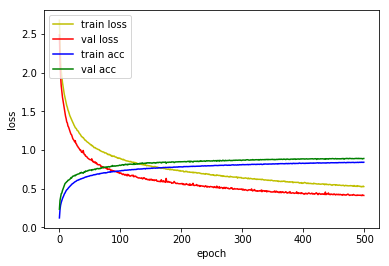

4815/4815 [==============================] - 2s 372us/sample - loss: 0.4625 - acc: 0.8704
Loss: 0.4625137715696174 Accuracy: 0.87040496

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5690 - acc: 0.1601
Epoch 00001: val_loss improved from inf to 2.14749, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/001-2.1475.hdf5
36805/36805 [==============================] - 32s 874us/sample - loss: 2.5690 - acc: 0.1601 - val_loss: 2.1475 - val_acc: 0.3247
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1290 - acc: 0.2914
Epoch 00002: val_loss improved from 2.14749 to 1.86509, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/002-1.8651.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 2.1290 - acc: 0.2913 - val_loss: 1.8651 - val_acc: 0.4428
Epoch 3/500
36736/36805 [============================>.] - ETA

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9275 - acc: 0.7221
Epoch 00023: val_loss improved from 0.74484 to 0.72684, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/023-0.7268.hdf5
36805/36805 [==============================] - 30s 819us/sample - loss: 0.9275 - acc: 0.7222 - val_loss: 0.7268 - val_acc: 0.7897
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9008 - acc: 0.7277
Epoch 00024: val_loss improved from 0.72684 to 0.71215, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/024-0.7122.hdf5
36805/36805 [==============================] - 30s 818us/sample - loss: 0.9011 - acc: 0.7277 - val_loss: 0.7122 - val_acc: 0.7992
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8813 - acc: 0.7390
Epoch 00025: val_loss did not improve from 0.71215
36805/36805 [==============================] - 30s 819us/sample - loss: 0.8810 - acc: 0.7391 -

36736/36805 [============================>.] - ETA: 0s - loss: 0.6283 - acc: 0.8179
Epoch 00045: val_loss did not improve from 0.47423
36805/36805 [==============================] - 30s 818us/sample - loss: 0.6286 - acc: 0.8178 - val_loss: 0.4894 - val_acc: 0.8717
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6265 - acc: 0.8186
Epoch 00046: val_loss improved from 0.47423 to 0.46037, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/046-0.4604.hdf5
36805/36805 [==============================] - 30s 819us/sample - loss: 0.6265 - acc: 0.8185 - val_loss: 0.4604 - val_acc: 0.8845
Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6192 - acc: 0.8210
Epoch 00047: val_loss did not improve from 0.46037
36805/36805 [==============================] - 30s 817us/sample - loss: 0.6196 - acc: 0.8209 - val_loss: 0.4619 - val_acc: 0.8819
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 70/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4916 - acc: 0.8581
Epoch 00070: val_loss did not improve from 0.36691
36805/36805 [==============================] - 30s 817us/sample - loss: 0.4916 - acc: 0.8581 - val_loss: 0.3739 - val_acc: 0.9038
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4879 - acc: 0.8592
Epoch 00071: val_loss improved from 0.36691 to 0.35997, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/071-0.3600.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 0.4879 - acc: 0.8592 - val_loss: 0.3600 - val_acc: 0.9047
Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4780 - acc: 0.8635
Epoch 00072: val_loss improved from 0.35997 to 0.35175, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/072-0.3517.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 0.4782 - acc: 0.8634 -

Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4089 - acc: 0.8796
Epoch 00095: val_loss improved from 0.30205 to 0.29921, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/095-0.2992.hdf5
36805/36805 [==============================] - 30s 819us/sample - loss: 0.4089 - acc: 0.8796 - val_loss: 0.2992 - val_acc: 0.9224
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4067 - acc: 0.8815
Epoch 00096: val_loss did not improve from 0.29921
36805/36805 [==============================] - 30s 821us/sample - loss: 0.4066 - acc: 0.8815 - val_loss: 0.3017 - val_acc: 0.9231
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4107 - acc: 0.8796
Epoch 00097: val_loss did not improve from 0.29921
36805/36805 [==============================] - 30s 819us/sample - loss: 0.4106 - acc: 0.8796 - val_loss: 0.3038 - val_acc: 0.9196
Epoch 98/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3513 - acc: 0.8964
Epoch 00121: val_loss did not improve from 0.27318
36805/36805 [==============================] - 30s 820us/sample - loss: 0.3513 - acc: 0.8964 - val_loss: 0.2848 - val_acc: 0.9278
Epoch 122/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3544 - acc: 0.8947
Epoch 00122: val_loss improved from 0.27318 to 0.26653, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/122-0.2665.hdf5
36805/36805 [==============================] - 30s 819us/sample - loss: 0.3544 - acc: 0.8947 - val_loss: 0.2665 - val_acc: 0.9313
Epoch 123/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3526 - acc: 0.8945
Epoch 00123: val_loss did not improve from 0.26653
36805/36805 [==============================] - 30s 821us/sample - loss: 0.3525 - acc: 0.8946 - val_loss: 0.2759 - val_acc: 0.9292
Epoch 124/500
36736/36805 [============================>.] - ETA: 0s - loss:

Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3139 - acc: 0.9041
Epoch 00148: val_loss improved from 0.25247 to 0.25189, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_5_conv_checkpoint/148-0.2519.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 0.3139 - acc: 0.9041 - val_loss: 0.2519 - val_acc: 0.9317
Epoch 149/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3055 - acc: 0.9081
Epoch 00149: val_loss did not improve from 0.25189
36805/36805 [==============================] - 30s 818us/sample - loss: 0.3055 - acc: 0.9081 - val_loss: 0.2536 - val_acc: 0.9345
Epoch 150/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3111 - acc: 0.9071
Epoch 00150: val_loss did not improve from 0.25189
36805/36805 [==============================] - 30s 819us/sample - loss: 0.3110 - acc: 0.9072 - val_loss: 0.2635 - val_acc: 0.9308
Epoch 151/500
36736/36805 [============================>.] - E

Epoch 175/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2790 - acc: 0.9152
Epoch 00175: val_loss did not improve from 0.24083
36805/36805 [==============================] - 30s 826us/sample - loss: 0.2792 - acc: 0.9151 - val_loss: 0.2431 - val_acc: 0.9373
Epoch 176/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2814 - acc: 0.9141
Epoch 00176: val_loss did not improve from 0.24083
36805/36805 [==============================] - 30s 816us/sample - loss: 0.2815 - acc: 0.9140 - val_loss: 0.2416 - val_acc: 0.9364
Epoch 177/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2795 - acc: 0.9148
Epoch 00177: val_loss did not improve from 0.24083
36805/36805 [==============================] - 30s 818us/sample - loss: 0.2795 - acc: 0.9148 - val_loss: 0.2443 - val_acc: 0.9378
Epoch 178/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2742 - acc: 0.9176
Epoch 00178: val_loss did not improve from 0.24083
36805/36805 [=

Epoch 203/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2560 - acc: 0.9214
Epoch 00203: val_loss did not improve from 0.23080
36805/36805 [==============================] - 30s 818us/sample - loss: 0.2560 - acc: 0.9214 - val_loss: 0.2378 - val_acc: 0.9385
Epoch 204/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2544 - acc: 0.9234
Epoch 00204: val_loss did not improve from 0.23080
36805/36805 [==============================] - 30s 818us/sample - loss: 0.2543 - acc: 0.9234 - val_loss: 0.2346 - val_acc: 0.9392
Epoch 205/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2525 - acc: 0.9220
Epoch 00205: val_loss did not improve from 0.23080
36805/36805 [==============================] - 30s 820us/sample - loss: 0.2525 - acc: 0.9220 - val_loss: 0.2410 - val_acc: 0.9369
Epoch 206/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9238
Epoch 00206: val_loss did not improve from 0.23080
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.2285 - acc: 0.9295
Epoch 00232: val_loss did not improve from 0.23080
36805/36805 [==============================] - 31s 830us/sample - loss: 0.2285 - acc: 0.9295 - val_loss: 0.2407 - val_acc: 0.9378
Epoch 233/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2278 - acc: 0.9294
Epoch 00233: val_loss did not improve from 0.23080
36805/36805 [==============================] - 31s 829us/sample - loss: 0.2277 - acc: 0.9293 - val_loss: 0.2458 - val_acc: 0.9392
Epoch 234/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2255 - acc: 0.9313
Epoch 00234: val_loss did not improve from 0.23080
36805/36805 [==============================] - 30s 822us/sample - loss: 0.2257 - acc: 0.9312 - val_loss: 0.2392 - val_acc: 0.9376
Epoch 235/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9294
Epoch 00235: val_loss did not improve from 0.23080
36805/36805 [===============

Epoch 261/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9347
Epoch 00261: val_loss did not improve from 0.22823
36805/36805 [==============================] - 30s 825us/sample - loss: 0.2110 - acc: 0.9347 - val_loss: 0.2372 - val_acc: 0.9390
Epoch 262/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2155 - acc: 0.9327
Epoch 00262: val_loss did not improve from 0.22823
36805/36805 [==============================] - 30s 827us/sample - loss: 0.2156 - acc: 0.9326 - val_loss: 0.2553 - val_acc: 0.9373
Epoch 263/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2092 - acc: 0.9353
Epoch 00263: val_loss did not improve from 0.22823
36805/36805 [==============================] - 30s 824us/sample - loss: 0.2093 - acc: 0.9353 - val_loss: 0.2342 - val_acc: 0.9413
Epoch 264/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2118 - acc: 0.9343
Epoch 00264: val_loss did not improve from 0.22823
36805/36805 [=

Epoch 291/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1930 - acc: 0.9400
Epoch 00291: val_loss did not improve from 0.22823
36805/36805 [==============================] - 30s 824us/sample - loss: 0.1929 - acc: 0.9400 - val_loss: 0.2385 - val_acc: 0.9418
Epoch 292/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1925 - acc: 0.9394
Epoch 00292: val_loss did not improve from 0.22823
36805/36805 [==============================] - 30s 827us/sample - loss: 0.1924 - acc: 0.9394 - val_loss: 0.2388 - val_acc: 0.9411
Epoch 293/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9392
Epoch 00293: val_loss did not improve from 0.22823
36805/36805 [==============================] - 30s 824us/sample - loss: 0.1952 - acc: 0.9392 - val_loss: 0.2300 - val_acc: 0.9397
Epoch 294/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1964 - acc: 0.9374
Epoch 00294: val_loss did not improve from 0.22823
36805/36805 [=

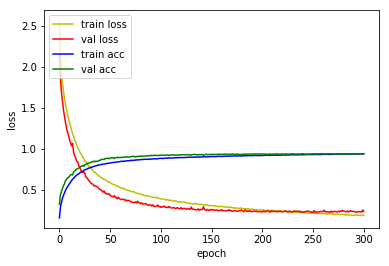

4815/4815 [==============================] - 2s 400us/sample - loss: 0.2658 - acc: 0.9234
Loss: 0.26581726950648416 Accuracy: 0.92336446

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4745 - acc: 0.1821
Epoch 00001: val_loss improved from inf to 1.94580, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_6_conv_checkpoint/001-1.9458.hdf5
36805/36805 [==============================] - 34s 927us/sample - loss: 2.4745 - acc: 0.1821 - val_loss: 1.9458 - val_acc: 0.3839
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9186 - acc: 0.3598
Epoch 00002: val_loss improved from 1.94580 to 1.61298, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_6_conv_checkpoint/002-1.6130.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 1.9185 - acc: 0.3598 - val_loss: 1.6130 - val_acc: 0.5080
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4913 - acc: 0.8535
Epoch 00023: val_loss improved from 0.35534 to 0.34179, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_6_conv_checkpoint/023-0.3418.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 0.4913 - acc: 0.8535 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4796 - acc: 0.8562
Epoch 00024: val_loss improved from 0.34179 to 0.32387, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_6_conv_checkpoint/024-0.3239.hdf5
36805/36805 [==============================] - 31s 850us/sample - loss: 0.4796 - acc: 0.8562 - val_loss: 0.3239 - val_acc: 0.9143
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4688 - acc: 0.8607
Epoch 00025: val_loss did not improve from 0.32387
36805/36805 [==============================] - 31s 843us/sample - loss: 0.4688 - acc: 0.8607 -

Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3078 - acc: 0.9073
Epoch 00047: val_loss improved from 0.21408 to 0.20102, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_6_conv_checkpoint/047-0.2010.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 0.3078 - acc: 0.9073 - val_loss: 0.2010 - val_acc: 0.9441
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2948 - acc: 0.9089
Epoch 00048: val_loss did not improve from 0.20102
36805/36805 [==============================] - 31s 844us/sample - loss: 0.2949 - acc: 0.9089 - val_loss: 0.2276 - val_acc: 0.9355
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2954 - acc: 0.9109
Epoch 00049: val_loss did not improve from 0.20102
36805/36805 [==============================] - 31s 845us/sample - loss: 0.2953 - acc: 0.9109 - val_loss: 0.2025 - val_acc: 0.9450
Epoch 50/500
36800/36805 [============================>.] - ETA: 

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2159 - acc: 0.9316
Epoch 00073: val_loss did not improve from 0.16349
36805/36805 [==============================] - 31s 847us/sample - loss: 0.2159 - acc: 0.9316 - val_loss: 0.1786 - val_acc: 0.9446
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.9316
Epoch 00074: val_loss did not improve from 0.16349
36805/36805 [==============================] - 31s 844us/sample - loss: 0.2179 - acc: 0.9316 - val_loss: 0.1704 - val_acc: 0.9536
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2140 - acc: 0.9333
Epoch 00075: val_loss did not improve from 0.16349
36805/36805 [==============================] - 31s 845us/sample - loss: 0.2140 - acc: 0.9333 - val_loss: 0.1664 - val_acc: 0.9539
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2113 - acc: 0.9351
Epoch 00076: val_loss improved from 0.16349 to 0.15766, saving model 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1671 - acc: 0.9471
Epoch 00100: val_loss did not improve from 0.14961
36805/36805 [==============================] - 31s 844us/sample - loss: 0.1671 - acc: 0.9471 - val_loss: 0.1621 - val_acc: 0.9550
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1654 - acc: 0.9474
Epoch 00101: val_loss did not improve from 0.14961
36805/36805 [==============================] - 31s 841us/sample - loss: 0.1654 - acc: 0.9474 - val_loss: 0.1598 - val_acc: 0.9578
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9476
Epoch 00102: val_loss did not improve from 0.14961
36805/36805 [==============================] - 31s 846us/sample - loss: 0.1643 - acc: 0.9476 - val_loss: 0.1635 - val_acc: 0.9567
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1602 - acc: 0.9490
Epoch 00103: val_loss did not improve from 0.14961
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9572
Epoch 00128: val_loss did not improve from 0.14257
36805/36805 [==============================] - 31s 841us/sample - loss: 0.1342 - acc: 0.9572 - val_loss: 0.1502 - val_acc: 0.9606
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9584
Epoch 00129: val_loss did not improve from 0.14257
36805/36805 [==============================] - 31s 842us/sample - loss: 0.1295 - acc: 0.9584 - val_loss: 0.1499 - val_acc: 0.9597
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1293 - acc: 0.9568
Epoch 00130: val_loss did not improve from 0.14257
36805/36805 [==============================] - 31s 840us/sample - loss: 0.1293 - acc: 0.9568 - val_loss: 0.1476 - val_acc: 0.9613
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1298 - acc: 0.9582
Epoch 00131: val_loss did not improve from 0.14257
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9654
Epoch 00157: val_loss did not improve from 0.14196
36805/36805 [==============================] - 31s 840us/sample - loss: 0.1068 - acc: 0.9654 - val_loss: 0.1434 - val_acc: 0.9630
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1070 - acc: 0.9648
Epoch 00158: val_loss did not improve from 0.14196
36805/36805 [==============================] - 31s 843us/sample - loss: 0.1070 - acc: 0.9648 - val_loss: 0.1616 - val_acc: 0.9618
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1063 - acc: 0.9647
Epoch 00159: val_loss did not improve from 0.14196
36805/36805 [==============================] - 31s 844us/sample - loss: 0.1063 - acc: 0.9647 - val_loss: 0.1586 - val_acc: 0.9613
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9668
Epoch 00160: val_loss did not improve from 0.14196
36805/36805 [===============

Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9704
Epoch 00187: val_loss did not improve from 0.14196
36805/36805 [==============================] - 31s 841us/sample - loss: 0.0855 - acc: 0.9704 - val_loss: 0.1623 - val_acc: 0.9641
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9723
Epoch 00188: val_loss did not improve from 0.14196
36805/36805 [==============================] - 31s 842us/sample - loss: 0.0843 - acc: 0.9723 - val_loss: 0.1455 - val_acc: 0.9618
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9720
Epoch 00189: val_loss did not improve from 0.14196
36805/36805 [==============================] - 31s 842us/sample - loss: 0.0845 - acc: 0.9720 - val_loss: 0.1522 - val_acc: 0.9627
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0873 - acc: 0.9710
Epoch 00190: val_loss did not improve from 0.14196
36805/36805 [=

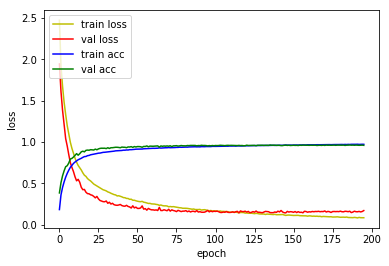

4815/4815 [==============================] - 2s 434us/sample - loss: 0.1792 - acc: 0.9485
Loss: 0.17919919491433156 Accuracy: 0.9484943

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3266 - acc: 0.2350
Epoch 00001: val_loss improved from inf to 1.58544, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/001-1.5854.hdf5
36805/36805 [==============================] - 35s 941us/sample - loss: 2.3264 - acc: 0.2350 - val_loss: 1.5854 - val_acc: 0.4992
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5036 - acc: 0.5141
Epoch 00002: val_loss improved from 1.58544 to 1.06838, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/002-1.0684.hdf5
36805/36805 [==============================] - 32s 863us/sample - loss: 1.5035 - acc: 0.5141 - val_loss: 1.0684 - val_acc: 0.6834
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.3048 - acc: 0.9059
Epoch 00023: val_loss improved from 0.20345 to 0.19899, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/023-0.1990.hdf5
36805/36805 [==============================] - 32s 862us/sample - loss: 0.3047 - acc: 0.9059 - val_loss: 0.1990 - val_acc: 0.9387
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2902 - acc: 0.9076
Epoch 00024: val_loss improved from 0.19899 to 0.18582, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/024-0.1858.hdf5
36805/36805 [==============================] - 32s 861us/sample - loss: 0.2901 - acc: 0.9076 - val_loss: 0.1858 - val_acc: 0.9436
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2786 - acc: 0.9143
Epoch 00025: val_loss improved from 0.18582 to 0.18246, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/025-0.1825.hdf5
36805/

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1483 - acc: 0.9517
Epoch 00049: val_loss improved from 0.13146 to 0.12949, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/049-0.1295.hdf5
36805/36805 [==============================] - 32s 862us/sample - loss: 0.1484 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9599
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1512 - acc: 0.9523
Epoch 00050: val_loss did not improve from 0.12949
36805/36805 [==============================] - 32s 859us/sample - loss: 0.1512 - acc: 0.9523 - val_loss: 0.1364 - val_acc: 0.9567
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1449 - acc: 0.9533
Epoch 00051: val_loss improved from 0.12949 to 0.12915, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_7_conv_checkpoint/051-0.1291.hdf5
36805/36805 [==============================] - 32s 860us/sample - loss: 0.1449 - acc: 0.9533 -

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9702
Epoch 00077: val_loss did not improve from 0.11964
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0888 - acc: 0.9702 - val_loss: 0.1217 - val_acc: 0.9639
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0871 - acc: 0.9714
Epoch 00078: val_loss did not improve from 0.11964
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0871 - acc: 0.9714 - val_loss: 0.1304 - val_acc: 0.9653
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0824 - acc: 0.9724
Epoch 00079: val_loss did not improve from 0.11964
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0824 - acc: 0.9724 - val_loss: 0.1337 - val_acc: 0.9653
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0849 - acc: 0.9719
Epoch 00080: val_loss did not improve from 0.11964
36805/36805 [=====

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9820
Epoch 00107: val_loss did not improve from 0.11964
36805/36805 [==============================] - 32s 859us/sample - loss: 0.0558 - acc: 0.9820 - val_loss: 0.1384 - val_acc: 0.9667
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9808
Epoch 00108: val_loss did not improve from 0.11964
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0565 - acc: 0.9808 - val_loss: 0.1382 - val_acc: 0.9651
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9832
Epoch 00109: val_loss did not improve from 0.11964
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0512 - acc: 0.9832 - val_loss: 0.1271 - val_acc: 0.9669
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9822
Epoch 00110: val_loss did not improve from 0.11964
36805/36805 [=

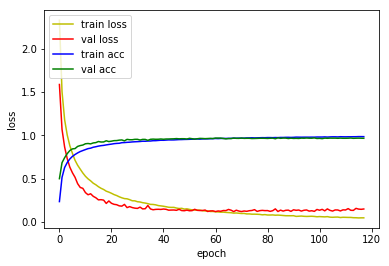

4815/4815 [==============================] - 2s 442us/sample - loss: 0.1847 - acc: 0.9433
Loss: 0.18465333684644472 Accuracy: 0.94330215

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1575 - acc: 0.3076
Epoch 00001: val_loss improved from inf to 1.21334, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_8_conv_checkpoint/001-1.2133.hdf5
36805/36805 [==============================] - 37s 999us/sample - loss: 2.1573 - acc: 0.3077 - val_loss: 1.2133 - val_acc: 0.6369
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1797 - acc: 0.6171
Epoch 00002: val_loss improved from 1.21334 to 0.78498, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_8_conv_checkpoint/002-0.7850.hdf5
36805/36805 [==============================] - 33s 888us/sample - loss: 1.1796 - acc: 0.6171 - val_loss: 0.7850 - val_acc: 0.7491
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1696 - acc: 0.9451
Epoch 00024: val_loss did not improve from 0.14497
36805/36805 [==============================] - 33s 885us/sample - loss: 0.1696 - acc: 0.9451 - val_loss: 0.1485 - val_acc: 0.9539
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1599 - acc: 0.9482
Epoch 00025: val_loss did not improve from 0.14497
36805/36805 [==============================] - 33s 884us/sample - loss: 0.1600 - acc: 0.9482 - val_loss: 0.1569 - val_acc: 0.9492
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1587 - acc: 0.9492
Epoch 00026: val_loss did not improve from 0.14497
36805/36805 [==============================] - 32s 881us/sample - loss: 0.1587 - acc: 0.9492 - val_loss: 0.1457 - val_acc: 0.9569
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1494 - acc: 0.9520
Epoch 00027: val_loss did not improve from 0.14497
36805/36805 [=====

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0623 - acc: 0.9784
Epoch 00052: val_loss did not improve from 0.12083
36805/36805 [==============================] - 33s 887us/sample - loss: 0.0623 - acc: 0.9784 - val_loss: 0.1446 - val_acc: 0.9609
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9794
Epoch 00053: val_loss did not improve from 0.12083
36805/36805 [==============================] - 33s 888us/sample - loss: 0.0608 - acc: 0.9794 - val_loss: 0.1610 - val_acc: 0.9557
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9795
Epoch 00054: val_loss did not improve from 0.12083
36805/36805 [==============================] - 33s 889us/sample - loss: 0.0610 - acc: 0.9795 - val_loss: 0.1330 - val_acc: 0.9632
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9802
Epoch 00055: val_loss did not improve from 0.12083
36805/36805 [=====

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9898
Epoch 00082: val_loss did not improve from 0.12083
36805/36805 [==============================] - 33s 885us/sample - loss: 0.0315 - acc: 0.9898 - val_loss: 0.1716 - val_acc: 0.9616
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9895
Epoch 00083: val_loss did not improve from 0.12083
36805/36805 [==============================] - 33s 891us/sample - loss: 0.0300 - acc: 0.9895 - val_loss: 0.1993 - val_acc: 0.9604
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9899
Epoch 00084: val_loss did not improve from 0.12083
36805/36805 [==============================] - 33s 891us/sample - loss: 0.0294 - acc: 0.9899 - val_loss: 0.1894 - val_acc: 0.9639
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9906
Epoch 00085: val_loss did not improve from 0.12083
36805/36805 [=====

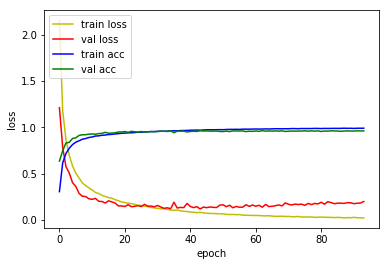

4815/4815 [==============================] - 2s 467us/sample - loss: 0.2023 - acc: 0.9458
Loss: 0.20229810329457804 Accuracy: 0.9457944



In [10]:
base = '1D_CNN_custom_multi_3_GAP_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GAP_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 2s 448us/sample - loss: 0.4625 - acc: 0.8704
Loss: 0.4625137715696174 Accuracy: 0.87040496

1D_CNN_custom_multi_3_GAP_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 64)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPooling1

4815/4815 [==============================] - 2s 456us/sample - loss: 0.1792 - acc: 0.9485
Loss: 0.17919919491433156 Accuracy: 0.9484943

1D_CNN_custom_multi_3_GAP_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 64)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooling1

4815/4815 [==============================] - 2s 483us/sample - loss: 0.2023 - acc: 0.9458
Loss: 0.20229810329457804 Accuracy: 0.9457944


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 2s 481us/sample - loss: 0.4678 - acc: 0.8687
Loss: 0.4678284607572348 Accuracy: 0.86874354

1D_CNN_custom_multi_3_GAP_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 64)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPooling1

4815/4815 [==============================] - 3s 520us/sample - loss: 0.1991 - acc: 0.9477
Loss: 0.19911163761623799 Accuracy: 0.94766355

1D_CNN_custom_multi_3_GAP_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 64)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooling

4815/4815 [==============================] - 3s 568us/sample - loss: 0.3125 - acc: 0.9472
Loss: 0.3124849086933695 Accuracy: 0.94724816
